In [39]:
exported_my_ratings = '9e02a92d-9120-4ae4-96ae-260878049286.csv'
selected_genres = [''] # or [''] to select all genres
negative_genres = ['Drama'] # or [''] to remove all negative genres
country = ''
min_year = 1930
max_year = 1960
quartile1 = 0 # In case of a "Memory error", increase
quartile3 = 0.6 # In case of a "Memory error", reduce

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
%matplotlib inline

In [41]:
data = pd.read_csv('data/ratings.csv')
data.drop('timestamp', axis=1, inplace=True)
data = data.dropna()
data['movieId'] = data['movieId'].astype('int64')
print(len(data))
data.head(2)

26024289


,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5


In [42]:
movies_data = pd.read_csv('data/movies_metadata.csv')
movies_data = movies_data.rename(columns={"id": "movieId"})
print(len(movies_data))
movies_data.head(2)

45466


C:\Users\ksn\AppData\Local\Temp\ipykernel_12856\1554198658.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_data = pd.read_csv('data/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [43]:
movies = movies_data.copy()

for i in movies_data.index:
    if re.findall('-', movies_data.iloc[i]['movieId']):
        movies.drop(i, inplace=True)

movies['movieId'] = movies['movieId'].astype('int64')
movies3 = movies[['movieId', 'vote_average', 'vote_count']].copy()

In [44]:
my_ratings = pd.read_csv(exported_my_ratings)
print(len(my_ratings))
my_ratings = my_ratings.rename(columns={"Const": "imdb_id", "Your Rating": "rating"})
my_ratings.head(2)

264


,imdb_id,rating,Date Rated,Title,Original Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt0022100,7,2025-09-18,М убийца,M - Eine Stadt sucht einen Mörder,https://www.imdb.com/title/tt0022100,Movie,8.3,117,1931,"Crime, Mystery, Thriller",179212,1931-08-31,Fritz Lang
1,tt10796286,9,2025-06-08,Дорогие товарищи!,Dorogie tovarishchi,https://www.imdb.com/title/tt10796286,Movie,7.4,121,2020,"Drama, History",6334,2020-11-12,Andrei Konchalovsky


In [45]:
my = my_ratings[['imdb_id', 'rating']].copy()
my['userId'] = 400000
ids = movies[['movieId', 'imdb_id']]
my = my.merge(ids, how='left', on='imdb_id')
my.drop('imdb_id', axis=1, inplace=True)
my.index = my['movieId']
my.head(2)

,rating,userId,movieId
movieId,,,
832.0,7,400000,832.0
NaN,9,400000,NaN


Delete movies from the data that are not in the table 'movies'

In [46]:
delta = set(data['movieId']) - set(movies['movieId'])
data_train = data.loc[~data['movieId'].isin(delta)]
len(data_train)

11436568

Creating genres table

In [47]:
genres = []

for i in range(len(movies)):
    genres.extend(list(map(lambda x: x[9:], re.findall("'name': '\w*", movies.iloc[i]['genres']))))

colms = list(set(genres))

df_genres = pd.DataFrame(columns=colms)
df_genres['movieId'] = movies['movieId']
df_genres = df_genres.fillna(0)
df_genres.index = df_genres['movieId']
df_genres.drop('movieId', axis=1, inplace=True)

for i in df_genres.index:
    genres = list(map(lambda x: x[9:], re.findall("'name': '\w*", str(movies.loc[movies['movieId'] == i]['genres']))))
    for j in genres:
        df_genres.at[i, j] = 1

sum_col = [sum(df_genres[i]) for i in df_genres.columns]

for i in df_genres.columns:
    if sum(df_genres[i]) < np.percentile(np.array(sum_col), 10):
        try:
            df_genres.drop(i, axis=1, inplace=True)
        except KeyError:
            pass

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
C:\Users\ksn\AppData\Local\Temp\ipykernel_12856\775438447.py:4: SyntaxWarning: invalid escape sequence '\w'
  genres.extend(list(map(lambda x: x[9:], re.findall("'name': '\w*", movies.iloc[i]['genres']))))
C:\Users\ksn\AppData\Local\Temp\ipykernel_12856\775438447.py:15: SyntaxWarning: invalid escape sequence '\w'
  genres = list(map(lambda x: x[9:], re.findall("'name': '\w*", str(movies.loc[movies['movieId'] == i]['genres']))))
C:\Users\ksn\AppData\Local\Temp\ipykernel_12856\775438447.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_genres = df_genres.fillna(0)


Limit by genres

In [48]:
if selected_genres[0] != '':
    my_genres = []
    for i in selected_genres:
        my_genres.extend(list(df_genres.loc[df_genres[i] == 1].index))
    my_genres = list(set(my_genres))
    data_train = data_train.loc[data_train['movieId'].isin(my_genres)]
    my = my.loc[my['movieId'].isin(my_genres)]
    movies3 = movies3.loc[movies3['movieId'].isin(my_genres)]
print(len(data_train))

11436568


In [49]:
if negative_genres[0] != '':
    my_neg_genres = []
    for i in negative_genres:
        my_neg_genres.extend(list(df_genres.loc[df_genres[i] == 1].index))
    data_train = data_train.loc[~data_train['movieId'].isin(my_neg_genres)]
    my = my.loc[~my['movieId'].isin(my_neg_genres)]
    movies3 = movies3.loc[~movies3['movieId'].isin(my_neg_genres)]
    print(len(data_train))

7666821


limit by years

In [50]:
movieId = []
year = []

for i in movies['movieId']:
    movieId.append(i)
    try:
        year.append(int(re.findall('[0-9]{4}-', str(movies.loc[movies['movieId'] == i]['release_date']))[0][0:4]))
    except IndexError:
        year.append(8888)

df_year = pd.DataFrame({'movieId': movieId, 'year': year})
df_year = df_year.loc[(df_year['year'] < max_year)&(df_year['year'] > min_year)]

data_train = data_train.loc[data_train['movieId'].isin(df_year['movieId'])]
my = my.loc[my['movieId'].isin(df_year['movieId'])]
movies3 = movies3.loc[movies3['movieId'].isin(df_year['movieId'])]
len(data_train)

787174

Limit by country

In [51]:
if country  != '':
    #Adding country column
    countries = []

    for i in movies.index:
        try:
            c = movies['production_countries'][i].replace("}, {", "}]comma[{").split('comma')
        except AttributeError:
            pass
    
        if len(c) > 1:
            for j in c:
                if j[17:19] not in ('CI', 'LA'):
                    countries.append(json.loads(j.replace("\'", "\"")[1:-1])['name'])
                    movies.at[i, 'countries'] = json.loads(j.replace("\'", "\"")[1:-1])['name']
        if len(c[0]) > 2:
            if c[0][17:19] not in ('CI', 'LA'):
                countries.append(json.loads(c[0].replace("\'", "\"")[1:-1])['name'])
                movies.at[i, 'countries'] = json.loads(c[0].replace("\'", "\"")[1:-1])['name']

    #Limit by country
    if country == 'Russia':
        selected_countries = list(movies.loc[(movies['countries'] == 'Soviet Union')|(movies['countries'] == 'Russia')]['movieId'])
    else:
        selected_countries = list(movies.loc[movies['countries'] == country]['movieId'])
    
    data_train = data_train.loc[data_train['movieId'].isin(selected_countries)]
    my = my.loc[my['movieId'].isin(selected_countries)]
    movies3 = movies3.loc[movies3['movieId'].isin(selected_countries)]
print(len(data_train))

787174


### Reducing amount of data

In [52]:
popularity_movie = data_train.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)
popularity_movie['rating_rank'] = popularity_movie['rating'].rank()
popularity_movie.drop('rating', axis=1, inplace=True)
popularity_movie.head(3)

,movieId,rating_rank
11,260,608.0
20,457,607.0
118,3578,606.0


In [53]:
data_train = pd.merge(data_train, popularity_movie, how='left', on='movieId')

In [54]:
user_sum_rating = data_train.groupby('userId')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_sum_rating.head(3)

,userId,rating_rank
0,45811,106238.5
1,8659,91392.0
2,179792,85912.0


In [55]:
user_count_rating = data_train.groupby('userId')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_count_rating.head(3)

,userId,rating_rank
0,45811,292
1,8659,211
2,179792,173


In [56]:
user_rating = pd.merge(user_sum_rating, user_count_rating, how='left', on='userId')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,userId,rating_rank
0,45811,363.830479
1,8659,433.137441
2,179792,496.601156


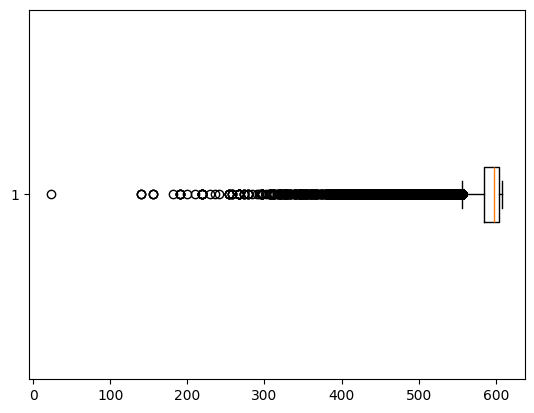

In [57]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

Selected interquartile range 

Q1=23.5, Q3=601.0


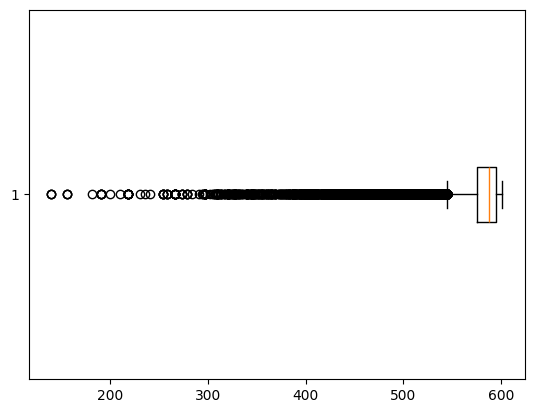

In [58]:
Q1 = user_rating['rating_rank'].quantile(quartile1)
Q3 = user_rating['rating_rank'].quantile(quartile3)
print(f'Q1={Q1}, Q3={Q3}')
user_rating_iqr = user_rating.loc[(user_rating['rating_rank'] < Q3) & (user_rating['rating_rank'] > Q1)]
user_list = user_rating_iqr['userId'].tolist()
plt.boxplot(user_rating_iqr['rating_rank'], vert=False)
plt.show()

In [59]:
data_train = data_train.loc[data_train['userId'].isin(user_list)]
data_train.drop('rating_rank', axis=1, inplace=True)
data_train = pd.concat([data_train, my], ignore_index=True)
len(data_train)

632632

In [60]:
import implicit
from scipy.sparse import csr_matrix

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=100,
                                        regularization=0.05, 
                                        alpha=2.0,
                                        iterations=20,
                                        random_state=38)

# train the model on a sparse matrix of user/item/confidence weights
user_item_matrix = pd.pivot_table(data_train,
                                  index='userId', columns='movieId',
                                  values='rating',
                                  fill_value=0)

# scipy resets indexes
idALS_movieId = dict((i, j) for i, j in enumerate(user_item_matrix.columns))

user_item_matrix = user_item_matrix.astype(float)
user_item_matrix_csr = csr_matrix(user_item_matrix).tocsr()

model.fit(user_item_matrix_csr)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.55it/s]


In [61]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
#user_item_matrix_csr = bm25_weight(user_item_matrix_csr, K1=100, B=0.8)

In [62]:
id_score = model.recommend(-1, user_item_matrix_csr[-1], N=250, filter_already_liked_items=True)
moviesId = [idALS_movieId[i] for i in id_score[0]]
ALScore = dict((i, j) for i, j in zip(moviesId, id_score[1]))

In [63]:
my_bt6 = my.loc[my['rating'] > 6]
my_genres = df_genres[df_genres.index.isin(my_bt6['movieId'])].mean().values

def rec_final(rec):
    name = []
    date = []
    url = []
    als_score = []
    score_imdb = []
    corr = []

    for i in rec:
        if i not in my.index:
            name.append(movies.loc[movies['movieId'] == i]['original_title'].values[0])
            date.append(movies.loc[movies['movieId'] == i]['release_date'].values[0])
            url.append('https://www.imdb.com/title/' + str(movies.loc[movies['movieId'] == i]['imdb_id'].values[0]))
            if type(rec) == list:
                als_score.append(ALScore[i])
            score_imdb.append(movies.loc[movies['movieId'] == i]['vote_average'].values[0])
            corr.append(0)
            if df_genres.loc[int(i)].sum().any() != 0:
                corr[-1] = (np.corrcoef(my_genres, df_genres.loc[int(i)])[0, 1])

    df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'score imdb': score_imdb, 'correlation': corr})
    df['rank'] = df['score imdb'].rank() + df['correlation'].rank()
    df = df.sort_values('rank', ascending=False)
    if type(rec) == list:
        df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'ALS score': als_score, 'score imdb': score_imdb, 'correlation': corr}).drop_duplicates()
        df['rank'] = df['score imdb'].rank() + df['ALS score'].rank() + df['correlation'].rank()
        df = df.sort_values('rank', ascending=False)
    return df

In [64]:
rec_final(moviesId).to_html(f'{" ".join(map((str), selected_genres))} {country} ALS recommendations {min_year} - {max_year}.html', encoding='utf-8', index=False, render_links=True)
rec_final(moviesId)[:10]

,name,date,url,ALS score,score imdb,correlation,rank
8,Mister Roberts,1955-07-13,https://www.imdb.com/title/tt0048380,1.110368,7.3,0.929944,676.5
46,Blondie Goes Latin,1941-02-27,https://www.imdb.com/title/tt0033403,0.581796,8.0,0.929944,663.5
26,The Dentist,1932-12-09,https://www.imdb.com/title/tt0022807,0.712673,7.1,0.929944,647.0
48,Arsenic and Old Lace,1944-09-23,https://www.imdb.com/title/tt0036613,0.571270,7.4,0.929944,643.0
6,The African Queen,1951-12-03,https://www.imdb.com/title/tt0043265,1.148694,7.4,0.274269,641.0
62,His Girl Friday,1940-01-18,https://www.imdb.com/title/tt0032599,0.482230,7.5,0.929944,633.5
23,Guys and Dolls,1955-11-03,https://www.imdb.com/title/tt0048140,0.723216,6.9,0.929944,627.0
90,"Pane, amore e gelosia",1954-01-01,https://www.imdb.com/title/tt0047327,0.358824,8.2,0.929944,623.0
14,Strangers on a Train,1951-06-18,https://www.imdb.com/title/tt0044079,0.963228,7.6,0.004285,614.5
54,Blondie Plays Cupid,1940-10-31,https://www.imdb.com/title/tt0032262,0.540027,7.0,0.929944,608.0


In [65]:
rec_final(popularity_movie['movieId'][:250]).to_html(f'{" ".join(map((str), selected_genres))} {country} movies from users dataset {min_year} - {max_year}.html', encoding='utf-8', index=False, render_links=True)

In [66]:
movies3['rank'] = movies3['vote_average'].rank() + movies3['vote_count'].rank()
rec_final(movies3.sort_values('rank', ascending=False)['movieId'][:250])\
.to_html(f'{" ".join(map((str), selected_genres))} {country} movies by score and popularity {min_year} - {max_year}.html', encoding='utf-8', index=False, render_links=True)